Resources:

- https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/




#### Dependencies

In [11]:
import os
import re
import json
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
from pathlib import Path
import numpy as np
import random
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, MACD, CCIIndicator
from ta.momentum import WilliamsRIndicator
from ta.volume import ChaikinMoneyFlowIndicator



In [12]:
print(torch.__version__)
print(torch.version.cuda) 
print(torch.cuda.is_available())   # True if a GPU is detected
print(torch.cuda.device_count())   # Number of GPUs available
# print(torch.cuda.get_device_name(0))  # Name of the first GPU

2.9.0+cu128
12.8
True
1


#### Utillity functions

In [13]:
def load_data(
    ticker: str,
    start_date: str,
    end_date: str,
    leadup_days: int = 30,
    interval: str = "1d",
    
):
    """
    Fetches price data with extra leadup_days for indicator warmup,
    computes technical indicators, and trims back to the exact start_date.
    """

    # Compute leadup start date
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    leadup_start_dt = start_dt - timedelta(days=leadup_days)
    leadup_start = leadup_start_dt.strftime("%Y-%m-%d")

    # Fetch data
    ticker_obj = yf.Ticker(ticker)
    df = ticker_obj.history(
        start=leadup_start,
        end=end_date,
        interval=interval,
        auto_adjust=False,
        actions=False
    )
    
    # Ensure columns are consistent
    df = df.copy()
    df.index = df.index.normalize()
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    
    return df

    

In [14]:
def add_indicators(df: pd.DataFrame, 
    # pred_target: int,
    # start_date: str,
    sma_vals=[10, 20]
    ):
    # Ensure columns are consistent
    df = df.copy()
    df.index = df.index.normalize()
    df.columns = df.columns.str.lower().str.replace(" ", "_")

    # === Add Indicators ===
    # SMA
    for i in sma_vals:
        df[f"sma_{i}"] = SMAIndicator(df["close"], window=i).sma_indicator()

    # Stochastic Oscillator
    stoch = StochasticOscillator(
        df["high"], df["low"], df["close"],
        window=14, smooth_window=3
    )
    df["stoch_k"] = stoch.stoch()
    df["stoch_d"] = stoch.stoch_signal()

    # MACD
    macd = MACD(df["close"], window_slow=26, window_fast=12, window_sign=9)
    df["macd"] = macd.macd()
    df["macd_signal"] = macd.macd_signal()
    df["macd_hist"] = macd.macd_diff()

    # CCI
    df["cci"] = CCIIndicator(df["high"], df["low"], df["close"], window=20).cci()

    # Williams %R
    df["williams_r"] = WilliamsRIndicator(df["high"], df["low"], df["close"], lbp=14).williams_r()

    # RSI
    df["rsi"] = RSIIndicator(df["close"], window=14).rsi()

    # ADOSC (Chaikin Money Flow)
    df["adosc"] = ChaikinMoneyFlowIndicator(
        high=df["high"],
        low=df["low"],
        close=df["close"],
        volume=df["volume"],
        window=20
    ).chaikin_money_flow()
    
    # # Log-return Prediction Target
    # daily_log_return = np.log(df["close"] / df["close"].shift(1))
    # df[f"{pred_target}_day_target"] = (
    #     daily_log_return.rolling(pred_target).sum().shift(-pred_target)
    # )

    # Drop NaNs caused by indicator warmup
    df = df.dropna()

    # Trim back to the actual start_date (remove leadup)
    # df = df[df.index >= (start_date)]

    return df

In [15]:
def generate_prediction_targets(df: pd.DataFrame, pred_targets: list) -> pd.DataFrame:
    """
    Adds multiple prediction horizon target columns to the dataframe using
    cumulative log returns.

    Example:
      pred_targets = [1, 5, 10, 15]
      → columns: ["1_day_target", "5_day_target", "10_day_target", "15_day_target"]
    """

    df = df.copy()
    daily = np.log(df["close"] / df["close"].shift(1))

    for t in pred_targets:
        df[f"{t}_day_target"] = daily.rolling(t).sum().shift(-t)

    return df

In [16]:
def plot_and_save_metrics(metrics_df, target_horizon, base_folder = "results", save_table=True):
      """Creates and saves three metric plots:
         (1) RMSE + MAE together
         (2) Directional Accuracy
         (3) Spearman Correlation
         (4) Metrics table of all years
         Files are named using the prediction horizon.
      """
      
      # Create directory name and ensure it exists
      folder_name = os.path.join(base_folder, f"target_{target_horizon}")
      os.makedirs(folder_name, exist_ok=True)

      years = metrics_df["year"]

      # --- Plot 1: RMSE + MAE ---
      fig1, ax1 = plt.subplots(figsize=(8, 4))
      ax1.plot(years, metrics_df["rmse"], marker="o", label="RMSE")
      ax1.plot(years, metrics_df["mae"], marker="o", label="MAE")
      ax1.set_title(f"RMSE & MAE ({target_horizon}-Day Horizon)")
      ax1.set_xlabel("Year")
      ax1.set_ylabel("Error Value")
      ax1.grid(True, alpha=0.3)
      ax1.legend()
      
      filename1 = f"metrics_target_{target_horizon}_RMSE_MAE.png"
      fig1.tight_layout()
      fig1.savefig(os.path.join(folder_name, "RMSE_MAE.png"), dpi=150)
      plt.close(fig1)


      # --- Plot 2: Directional Accuracy ---
      
      fig2, ax2 = plt.subplots(figsize=(8, 4))
      ax2.plot(years, metrics_df["directional_accuracy (%)"], marker="s", linestyle="--")
      ax2.set_ylim(0, 100)
      ax2.set_title(f"Directional Accuracy ({target_horizon}-Day Horizon)")
      ax2.set_xlabel("Year")
      ax2.set_ylabel("Directional Accuracy (%)")
      ax2.grid(True, alpha=0.3)

      filename2 = f"metrics_target_{target_horizon}_Directional_Accuracy.png"
      fig2.tight_layout()
      fig2.savefig(os.path.join(folder_name, "Directional_Accuracy.png"), dpi=150)
      plt.close(fig2)


      # --- Plot 3: Spearman Correlation ---
      fig3, ax3 = plt.subplots(figsize=(8, 4))
      ax3.plot(years, metrics_df["spearman"], marker="s", linestyle=":")
      ax3.set_title(f"Spearman Correlation ({target_horizon}-Day Horizon)")
      ax3.set_xlabel("Year")
      ax3.set_ylabel("Spearman")
      ax3.grid(True, alpha=0.3)

      filename3 = f"metrics_target_{target_horizon}_Spearman.png"
      fig3.tight_layout()
      fig3.savefig(os.path.join(folder_name, "Spearman.png"), dpi=150)
      plt.close(fig3)
      
      
      # save the df for good measure
      df_file = f"metrics_target_{target_horizon}.csv"
      # optional table save 
      if save_table:
        metrics_df.to_csv(os.path.join(folder_name, "metrics.csv"), index=False)
      

      print("\nSaved plots:")
      print(f" - {filename1}")
      print(f" - {filename2}")
      print(f" - {filename3}")
      print(f" - {df_file}")


In [17]:
def collect_target_metrics(save_table=True, base_folder="meta_analysis", seed=42):
    """
    Collects metrics.csv files from folders named result_target_[TARGET]
    and returns a combined dataframe sorted by TARGET value.
    """
    # Get the directory of the current script
    base_dir = Path.cwd()
    results_path = base_dir / "results"
    
    # Create the folder structure: base_folder -> seed
    target_folder = base_dir / base_folder / f"seed{seed}"
    target_folder.mkdir(parents=True, exist_ok=True)

    combined_results = []
    print("Folders found:", os.listdir(results_path))
    
    # Regex to detect folders like result_target_5, result_target_10, etc.
    folder_pattern = re.compile(r"target_(\d+)")
    for folder_name in os.listdir(results_path):
        
        match = folder_pattern.match(folder_name)
        if match:
            target_value = int(match.group(1))
            metrics_file = os.path.join(results_path, folder_name, "metrics.csv")
            # print(f"Checking: {metrics_file}")

            if os.path.exists(metrics_file):
                df = pd.read_csv(metrics_file)
                df["pred_target"] = target_value
                combined_results.append(df)
            else:
                print(f"WARNING: {metrics_file} not found.")

    # Combine all collected data
    if combined_results:
        final_df = pd.concat(combined_results, ignore_index=True)
        final_df = final_df.set_index(["pred_target", "year"]).sort_index()
        if save_table:
            save_path = target_folder / f"combined_metrics_seed{seed}.csv"
            final_df.to_csv(save_path)
            print(f"Saved combined file to: {save_path}")
        
        return final_df
    else:
        print("No metrics.csv files found.")
        return pd.DataFrame()

In [18]:
def generate_metrics(results):
    """
    Generate yearly prediction performance metrics from model results.

    Parameters
    ----------
    results : list[pd.DataFrame]
        A list of DataFrames where each contains:
        ['date', 'prediction', 'actual']

    Returns
    -------
    pd.DataFrame
        Metrics sorted by year containing:
        RMSE, MAE, Directional Accuracy (%), and Spearman Rank Correlation.
    """

    year_stats = []

    for df_year in results:  # each entry is a year dataframe

        year = df_year['date'].iloc[0].year  # extract year from first row's date

        preds = df_year["prediction"].values
        actual = df_year["actual"].values

        # Metrics
        rmse = np.sqrt(mean_squared_error(actual, preds))
        mae = mean_absolute_error(actual, preds)
        
        # directional accuracy
        direction_accuracy = (np.sign(preds) == np.sign(actual)).mean()

        # Spearman correlation (ignore NaNs)
        spearman_val, _ = spearmanr(actual, preds, nan_policy='omit')

        year_stats.append({
            "year": year,
            "rmse": rmse,
            "mae": mae,
            "directional_accuracy (%)": round(direction_accuracy * 100, 2),
            "spearman": spearman_val
        })

    # Convert results into a table
    return pd.DataFrame(year_stats).sort_values("year").reset_index(drop=True)

#### Model

In [19]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch, seq_len, features)
        output, (hidden, _) = self.lstm(x)
        last_hidden = hidden[-1]
        return self.fc(last_hidden)
    

In [20]:
def save_experiment(model, config, metrics_df, target_horizon, feature_scaler, target_scaler):
    
    os.makedirs("models", exist_ok=True)

    # Save checkpoint
    checkpoint_path = os.path.join("models", f"experiment_target_{target_horizon}.pth")
    torch.save({
        "model_config": config,
        "weights": model.state_dict(),
        "metrics": metrics_df.to_dict(),
        "target_horizon": target_horizon,
        "feature_scaler": feature_scaler,
        "target_scaler": target_scaler,
    }, checkpoint_path)

    # Save config separately as JSON
    config_path = os.path.join("models", f"config_target_{target_horizon}.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)

    print(f"\nSaved model + config to models/:")
    print(f" - {checkpoint_path}")
    print(f" - {config_path}")

In [21]:
def make_seed(fixed=None):
    """Returns a deterministic seed if provided, otherwise generates a random one."""
    return fixed if fixed is not None else np.random.randint(1, 1_000_000)

In [22]:
def apply_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [23]:
def load_checkpoint(pred_target: int, base_folder="models"):
    """
    Loads a checkpoint saved using `save_experiment()`
    and returns: (state_dict, config, metrics, target_horizon, device)
    """
    
    # Allow StandardScaler to be unpickled safely
    torch.serialization.add_safe_globals([StandardScaler])

    
    base = Path.cwd() / base_folder
    checkpoint_path = base / f"experiment_target_{pred_target}.pth"

    if not checkpoint_path.exists():
        raise FileNotFoundError(f"No checkpoint found at: {checkpoint_path}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

    return {
    "weights": checkpoint["weights"],
    "config": checkpoint["model_config"],
    "metrics": checkpoint.get("metrics", None),
    "target_horizon": checkpoint["target_horizon"],
    "feature_scaler": checkpoint["feature_scaler"],
    "target_scaler": checkpoint["target_scaler"],
    "device": device
}

In [24]:
def make_sequences(feature_array, target_array, seq_len):
    """
    feature_array: np.ndarray shape (num_samples, num_features)
    target_array : np.ndarray shape (num_samples,)
    seq_len      : sequence length
    
    Returns sliding window feature sequences and corresponding future targets.
    Rows where the target value is NaN are skipped.
    """
    
    X, y = [], []

    for i in range(len(feature_array) - seq_len):
        target = target_array[i + seq_len]
        if np.isnan(target):
            continue  # skip incomplete horizon labels
        X.append(feature_array[i : i + seq_len])
        y.append(target)

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [25]:
def load_model_and_predict(pred_target: int, df: pd.DataFrame):
    

    # Load checkpoint
    checkpoint = load_checkpoint(pred_target)
    config = checkpoint["config"]
    device = checkpoint["device"]
    
    feature_scaler = checkpoint["feature_scaler"]
    target_scaler  = checkpoint["target_scaler"]

    #  Build model (CPU by default)
    model = LSTMPredictor(
        input_dim=config["input_dim"],
        hidden_dim=config["hidden_dim"],
        num_layers=config["num_layers"],
        dropout=config["dropout"]
    )

    # Load weights first
    model.load_state_dict(checkpoint["weights"])
    model.to(device)
    model.eval()
    
    # Scale features using stored scaler
    feature_values = feature_scaler.transform(df[config["feature_cols"]])

    # Raw test horizon targets (needed only for evaluation)
    target_values = df[f"{pred_target}_day_target"].to_numpy()

    # Build sequences
    seq_len = config["seq_len"]
    X, _ = make_sequences(feature_array=feature_values,
                        target_array=target_values,
                      seq_len=seq_len)

    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    # Predict
    preds_scaled = model(X_tensor).detach().cpu().numpy().reshape(-1,1)
    
    # Inverse scale to real-world returns
    preds = target_scaler.inverse_transform(preds_scaled).flatten()

    valid_indices = [
            i for i in range(len(target_values) - seq_len)
            if not np.isnan(target_values[i + seq_len])
            ]

    valid_dates = df.index[[i + seq_len for i in valid_indices]][:len(preds)]
    valid_targets = target_values[[i + seq_len for i in valid_indices]][:len(preds)]

    pred_df = pd.DataFrame({
        "prediction": preds,
        "actual": valid_targets,
        "target_horizon": pred_target
    }, index=valid_dates)

    return {
        "predictions": pred_df,
        "config": config,
        "metrics": checkpoint.get("metrics", None),
    }

#### Training Loop

In [26]:
def walk_forward_training_loop(df, target_col, feature_cols,
    PRED_TARGET=15, 
    SEQ_LEN=10,
    START_YEAR=2015,
    END_YEAR=2025,
    LEARNING_RATE=0.001,
    HIDDEN_DIM=64,
    NUM_LAYERS=2,
    DROPOUT=0.2,
    WEIGHT_SEED=42,
    BATCH_SIZE=32,
    EPOCHS=10):

    results = []
    
    last_feature_scaler = None
    last_target_scaler = None
    last_model = None

    for year in range(START_YEAR, END_YEAR):
        print(f"\n=== WALK {year} ===")

        # find actual first trading day of the year
        test_start = df[df.index >= f"{year}-01-01"].index.min()
        if pd.isna(test_start):
            print(f"[SKIP] No rows for year {year}")
            continue

        # rolling expand training set, strict 1-year forecast window
        train = df[df.index < test_start]
        test  = df[(df.index >= test_start) & (df.index < f"{year+1}-01-01")]
        
        # drop all rows containing missing values
        train = train.dropna(subset=feature_cols)
        test  = test.dropna(subset=feature_cols)

        if len(train) < SEQ_LEN:
            print(f"[WAIT] Not enough history ({len(train)} rows, need {SEQ_LEN}) — skipping.")
            continue

         # FEATURE SCALING 
        feature_scaler = StandardScaler()
        scaled_train_features = feature_scaler.fit_transform(train[feature_cols])
        scaled_test_features  = feature_scaler.transform(test[feature_cols])

        # TARGET SCALING 
        target_scaler = StandardScaler()
        scaled_train_target = target_scaler.fit_transform(train[[target_col]]).flatten()

        # Extract raw values for test target (unscaled)
        test_target_original = test[target_col].to_numpy()

        # Build sequences

        # Training data: scaled features + scaled target
        X_train, y_train = make_sequences(
            feature_array = scaled_train_features,
            target_array  = scaled_train_target,
            seq_len       = SEQ_LEN
        )

        # Test sequences (scaled features, unscaled target)
        X_test, y_test_original = make_sequences(
            feature_array = scaled_test_features,
            target_array  = test_target_original,
            seq_len       = SEQ_LEN
        )

        # Convert to tensors 
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

        X_test_t  = torch.tensor(X_test, dtype=torch.float32)  # scaled test features only

        # reproducibility
        apply_seed(WEIGHT_SEED)


        # fresh model
        model = LSTMPredictor(
            input_dim=len(feature_cols),
            hidden_dim=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT
        )

        loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=False)

        # optimizer
        opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        loss_fn = nn.MSELoss()

        # train
        for epoch in range(EPOCHS):
            for xb, yb in loader:
                opt.zero_grad()
                loss = loss_fn(model(xb), yb)
                loss.backward()
                opt.step()
        
        # Predict and inverse transform
        preds_scaled = model(X_test_t).detach().numpy().reshape(-1,1)
        preds = target_scaler.inverse_transform(preds_scaled).flatten()
        
        # Use original unscaled test targets
        real_y_test = y_test_original

        pred_dates = test.index[SEQ_LEN:]  # Use original test index

        results.append(pd.DataFrame({
            "date": pred_dates,
            "prediction": preds,
            "actual": real_y_test[-len(preds):]
        }))
        
        # Store the last scalers and model
        last_feature_scaler = feature_scaler
        last_target_scaler = target_scaler
        last_model = model

    config = {
        "input_dim": len(feature_cols),
        "hidden_dim": HIDDEN_DIM,
        "num_layers": NUM_LAYERS,
        "dropout": DROPOUT,
        "seq_len": SEQ_LEN,
        "target_horizon": PRED_TARGET,
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS,
        "weight_init_seed": WEIGHT_SEED,
        "batch_size": BATCH_SIZE,
        "feature_cols": feature_cols
    }

    return results, last_model, config, last_feature_scaler, last_target_scaler

#### Operation Pipeline

In [27]:
#INIT PARAMS
    # Dataset/Time
TICKER = "AMZN"
START = "2015-01-01"
END = "2025-01-01"
Y_START = 2015
Y_END = 2023
WARMUP = 80
TARGET = 15
SMA = [10, 20]
    # Model
SEED = make_seed(42)
LOOKBACK = 20
DIM = 64
LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 25

In [28]:
# Load full data
df_raw = load_data(
    ticker=TICKER,
    start_date=START,
    end_date=END,
    leadup_days=WARMUP,
)

#### DryRun

In [30]:
# 1. add indicators
df = add_indicators(df=df_raw, sma_vals=SMA)
df = generate_prediction_targets(df, [TARGET])
# display(df)
# 2. Create walk-forward boundary

# leave last two years for final testing untouched during training.
train_df = df[df.index < "2023-01-01"]
test_df  = df[df.index >= "2023-01-01"]


# 3. Train the model using WalkForward testing split
# use all columns as features except target column
feature_cols = [col for col in df.columns if col not in [f"{TARGET}_day_target"]]
target_col = f"{TARGET}_day_target"

results, model, config, feature_scaler, target_scaler = walk_forward_training_loop(
    train_df, target_col, 
    feature_cols,
    PRED_TARGET=TARGET,
    SEQ_LEN=LOOKBACK, 
    START_YEAR=Y_START, 
    END_YEAR=Y_END, 
    LEARNING_RATE= LEARNING_RATE, 
    HIDDEN_DIM= DIM, 
    NUM_LAYERS= LAYERS, 
    DROPOUT= DROPOUT,
    EPOCHS=EPOCHS,
    WEIGHT_SEED=SEED,
    BATCH_SIZE=BATCH_SIZE
    
)

# 4. Convert results into a table
metrics_df = generate_metrics(results=results)

# 5. store results
plot_and_save_metrics(metrics_df, TARGET)
save_experiment(model, config, metrics_df, TARGET, feature_scaler=feature_scaler, target_scaler=target_scaler)




=== WALK 2015 ===

=== WALK 2016 ===

=== WALK 2017 ===

=== WALK 2018 ===

=== WALK 2019 ===

=== WALK 2020 ===

=== WALK 2021 ===

=== WALK 2022 ===

Saved plots:
 - metrics_target_15_RMSE_MAE.png
 - metrics_target_15_Directional_Accuracy.png
 - metrics_target_15_Spearman.png
 - metrics_target_15.csv

Saved model + config to models/:
 - models\experiment_target_15.pth
 - models\config_target_15.json


In [31]:
metrics_df

,year,rmse,mae,directional_accuracy (%),spearman
0,2015,0.090816,0.071272,31.90,0.028292
1,2016,0.151180,0.135365,49.57,0.277806
2,2017,0.095441,0.078440,41.56,-0.039141
3,2018,0.105843,0.086918,64.94,-0.046474
4,2019,0.075306,0.062113,42.67,-0.214049
5,2020,0.124452,0.105083,36.05,0.085068
6,2021,0.064711,0.052299,54.74,0.093078
7,2022,0.142088,0.117763,38.10,0.024175


In [32]:
# combine all metric csv's in the results folders
metrics_combined = collect_target_metrics(SEED)
# metrics_combined
# metrics_combined.swaplevel("year", "pred_target")

Folders found: ['target_1', 'target_10', 'target_15', 'target_20', 'target_25', 'target_30', 'target_5']
Saved combined file to: c:\Projects\AgenticTrader\NN\meta_analysis\seed42\combined_metrics_seed42.csv


#### meta-experiment layer

Goal: Finding the most suitable prediction horizon to use as baseline

- Directional Accuracy: "How often is the sign of the predicted return correct?"
- Spearman: How well do the ranks of prediction match the ranks of realized returns

signal quality metrics say something about whether
- there is any predictable structure at a horizon
- it is more structured than random
- structure improves or degrades as horizon increases

key findings:

short horizons (1 - 5): noisy, weak structure

mid horizons (15 - 30): higher directional accuracy, still weak spearman ranking

DA + IC are good for identifying where the market is learnable

In [33]:
def run_multi_horizon_experiments(
    df,
    horizons,
    seed=42,   # each horizon will mutate from this
    seq_len=10,
    start_year=2015,
    end_year=2022,
    learning_rate=0.001,
    hidden_dim=64,
    num_layers=2,
    dropout=0.2,
    batch_size=32,
    epochs=10
):
    
    """
    Runs multiple forecasting experiments, one model per prediction horizon.

    For each horizon:
      - selects the matching target column (e.g., "15_day_target")
      - excludes all other target columns from the feature set
      - trains and evaluates the model using walk-forward validation
      - saves model weights, scalers, plots and metrics to disk

    Parameters
    ----------
    df : pd.DataFrame
        Complete dataset containing features and all horizon target columns.

    horizons : list[int]
        List of forecast horizons to train (e.g., [5, 15, 30]).

    seed : int
        Base seed for reproducibility. Each horizon offsets this seed.

    seq_len : int
        Lookback window length used to generate input sequences.

    start_year, end_year : int
        Defines the period used for walk-forward testing.

    Training/evaluation settings (learning_rate, hidden_dim, dropout, etc.)
    are passed through to the underlying walk-forward loop.

    Returns
    -------
    pd.DataFrame
        A summary table containing aggregated performance metrics
        (RMSE, MAE, directional accuracy, etc.) for each horizon.
    """

    all_results = []  # stores summary for comparison

    for i, horizon in enumerate(horizons):

        

        print("\n" + "="*50)
        print(f"Running experiment for horizon: {horizon} days")
        print("="*50)

        # 1) Assign target column name for this horizon
        target_col_name = f"{horizon}_day_target"

        if target_col_name not in df.columns:
            raise ValueError(f"Missing column {target_col_name}. Did load_price_data generate these?")

        target_col = target_col_name

        # 2) Feature cols = everything except target columns
        all_target_cols = [f"{h}_day_target" for h in horizons]
        
        feature_cols = [c for c in df.columns if c not in all_target_cols]

        # 3) Walk-forward training
        results, model, config, feature_scaler, target_scaler = walk_forward_training_loop(
            df[df.index < "2023-01-01"],   # train
            target_col,
            feature_cols,
            WEIGHT_SEED=seed + i, # iterate seed to prevent misleading correlation
            PRED_TARGET=horizon,
            SEQ_LEN=seq_len,
            START_YEAR=start_year,
            END_YEAR=end_year,
            LEARNING_RATE=learning_rate,
            HIDDEN_DIM=hidden_dim,
            NUM_LAYERS=num_layers,
            DROPOUT=dropout,
            BATCH_SIZE=batch_size,
            EPOCHS=epochs
        )
        
        # Add experiment-specific metadata
        config["feature_cols"] = feature_cols
        config["target_col"] = target_col
        config["horizon"] = horizon

        # 4) Compute metrics
        metrics = generate_metrics(results)

        # 5) Save model + metrics + plots
        plot_and_save_metrics(metrics, horizon)
        save_experiment(model, config, metrics, horizon, feature_scaler=feature_scaler,target_scaler=target_scaler)

In [34]:
HORIZONS = [1, 5, 10, 15, 20, 25, 30]
# 1. add indicators
df = add_indicators(df=df_raw, sma_vals=SMA)
df = generate_prediction_targets(df, HORIZONS)
# display(df)

# 2. Create walk-forward boundary
# leave last two years for final testing untouched during training.
train_df = df[df.index < "2023-01-01"]
backtest_df  = df[df.index >= "2023-01-01"]

# 3. training loop
summary_df = run_multi_horizon_experiments(
    df=train_df,
    horizons=HORIZONS,
    seed=SEED,
    seq_len=LOOKBACK,
    start_year=Y_START,
    end_year=Y_END,
    learning_rate=LEARNING_RATE,
    hidden_dim=DIM,
    num_layers=LAYERS,
    dropout=DROPOUT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# 4. combine all metric csv's in the results folders
metrics_combined = collect_target_metrics(seed=SEED)


Running experiment for horizon: 1 days

=== WALK 2015 ===

=== WALK 2016 ===

=== WALK 2017 ===

=== WALK 2018 ===

=== WALK 2019 ===

=== WALK 2020 ===

=== WALK 2021 ===

=== WALK 2022 ===

Saved plots:
 - metrics_target_1_RMSE_MAE.png
 - metrics_target_1_Directional_Accuracy.png
 - metrics_target_1_Spearman.png
 - metrics_target_1.csv

Saved model + config to models/:
 - models\experiment_target_1.pth
 - models\config_target_1.json

Running experiment for horizon: 5 days

=== WALK 2015 ===

=== WALK 2016 ===

=== WALK 2017 ===

=== WALK 2018 ===

=== WALK 2019 ===

=== WALK 2020 ===

=== WALK 2021 ===

=== WALK 2022 ===

Saved plots:
 - metrics_target_5_RMSE_MAE.png
 - metrics_target_5_Directional_Accuracy.png
 - metrics_target_5_Spearman.png
 - metrics_target_5.csv

Saved model + config to models/:
 - models\experiment_target_5.pth
 - models\config_target_5.json

Running experiment for horizon: 10 days

=== WALK 2015 ===

=== WALK 2016 ===

=== WALK 2017 ===

=== WALK 2018 ===

==

#### Meta_analysis plotting functions

In [35]:
def plot_directional_accuracy(df: pd.DataFrame, base_folder: str, timestamp: datetime, seed=42):
    
     # Create folder structure using Path
    folder_path = Path(base_folder) / f"seed{seed}"
    folder_path.mkdir(parents=True, exist_ok=True)

    
    plt.figure(figsize=(12,6))

    for horizon in df.index.levels[0]:  
        series = df.loc[horizon]["directional_accuracy (%)"]
        plt.plot(
            series.index, 
            series.values, 
            marker="o", 
            label=f"{horizon}-day"
        )

    plt.title("Directional Accuracy Across Forecast Horizons")
    plt.ylim(0, 100)
    plt.xlabel("Year")
    plt.ylabel("Directional Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Forecast Horizon")
    
    # Save
    filename = f"DA_ALL_seed{seed}_{timestamp}.png"
    save_path = folder_path / filename
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {save_path}")
    return plt.gcf()

In [36]:
def plot_spearman(df: pd.DataFrame, base_folder: str, timestamp: datetime,seed=42):
    
    # Create folder structure using Path
    folder_path = Path(base_folder) / f"seed{seed}"
    folder_path.mkdir(parents=True, exist_ok=True)
    
    plt.figure(figsize=(12,6))

    for horizon in  df.index.levels[0]:
        series = df.loc[horizon]["spearman"]
        plt.plot(
            series.index, 
            series.values, 
            marker="o", linestyle="--", 
            label=f"{horizon}-day"
        )

    plt.title("Spearman Information Coefficient by Prediction Horizon")
    plt.xlabel("Year")
    plt.ylabel("Spearman Correlation")
    plt.axhline(0, color="black", linewidth=1)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Forecast Horizon", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    
    # Save
    filename = f"IC_ALL_seed{seed}_{timestamp}.png"
    save_path = folder_path / filename
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {save_path}")
    return plt.gcf()

In [37]:
def plot_DA_mean(df: pd.DataFrame, base_folder:str, timestamp: datetime, seed=42):
    
    # Create folder structure using Path
    folder_path = Path(base_folder) / f"seed{seed}"
    folder_path.mkdir(parents=True, exist_ok=True)
    
    plt.figure(figsize=(10,5))
    summary = df.groupby(level=0)["directional_accuracy (%)"].mean()
    plt.plot(summary.index, summary.values, marker="o")
    plt.title("Mean Directional Accuracy vs Prediction Horizon")
    plt.xlabel("Horizon (days)")
    plt.ylabel("Directional Accuracy (%)")
    plt.grid(True)
    
    # Save
    filename = f"mean_DA_seed{seed}_{timestamp}.png"
    save_path = folder_path / filename
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {save_path}")
    return plt.gcf()

In [38]:
def plot_IC_mean(df: pd.DataFrame, base_folder: str, timestamp: datetime, seed=42):
    
    # Create folder structure using Path
    folder_path = Path(base_folder) / f"seed{seed}"
    folder_path.mkdir(parents=True, exist_ok=True)
    
    summary_ic = df.groupby(level=0)["spearman"].mean()
    plt.figure(figsize=(10,5))
    plt.plot(summary_ic.index, summary_ic.values, marker="o")
    plt.title("Mean Spearman IC vs Prediction Horizon")
    plt.xlabel("Horizon (days)")
    plt.ylabel("Spearman")
    plt.axhline(0, color="black")
    plt.grid(True)
    
    # Save
    filename = f"mean_IC_seed{seed}_{timestamp}.png"
    save_path = folder_path / filename
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {save_path}")
    return plt.gcf()

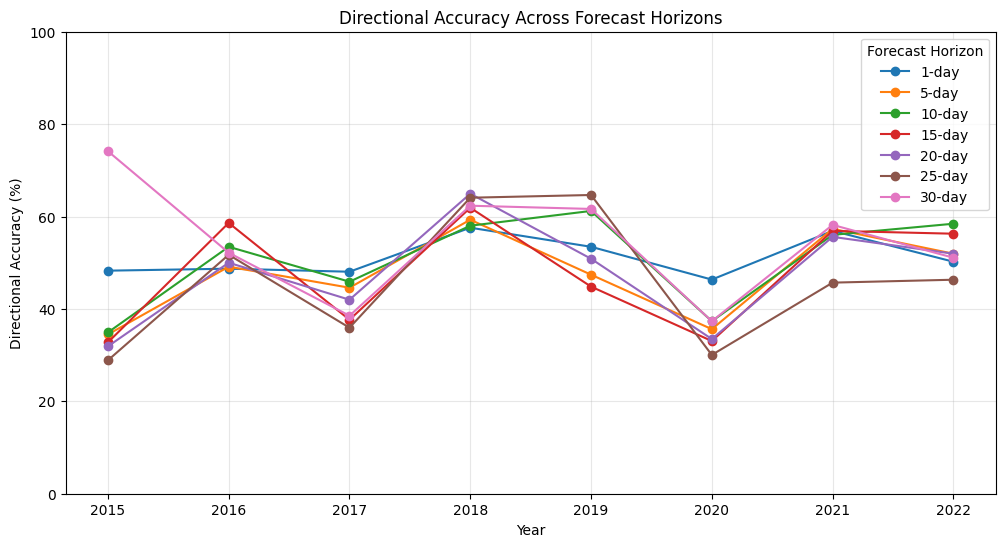

Plot saved to: meta_analysis\seed42\DA_ALL_seed42_20251130_235527.png


<Figure size 640x480 with 0 Axes>

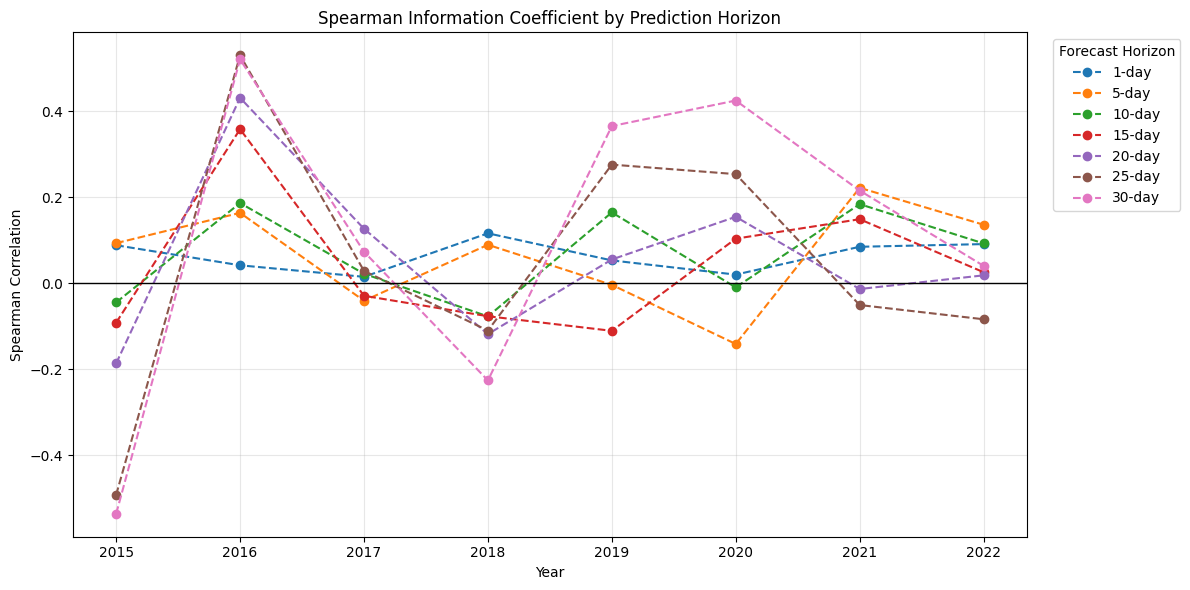

Plot saved to: meta_analysis\seed42\IC_ALL_seed42_20251130_235527.png


<Figure size 640x480 with 0 Axes>

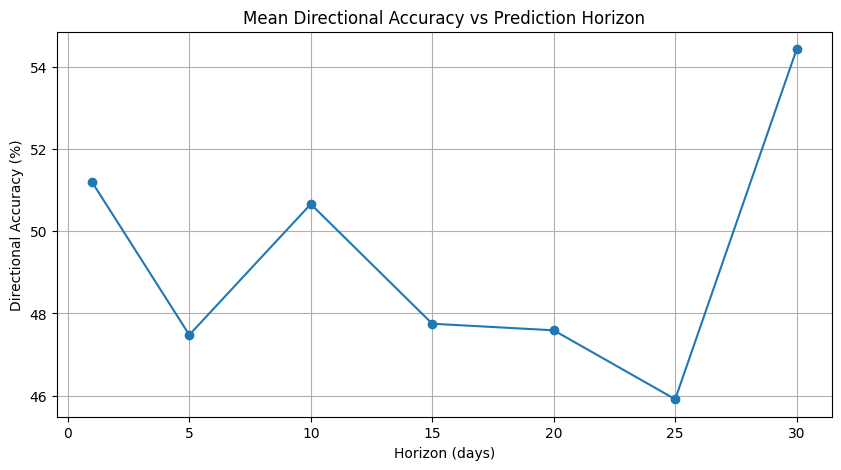

Plot saved to: meta_analysis\seed42\mean_DA_seed42_20251130_235527.png


<Figure size 640x480 with 0 Axes>

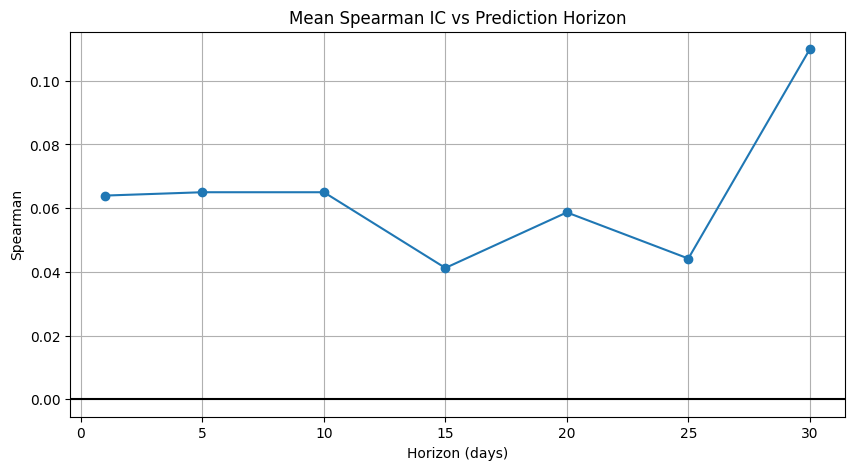

Plot saved to: meta_analysis\seed42\mean_IC_seed42_20251130_235527.png


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [39]:
time = datetime.now().strftime("%Y%m%d_%H%M%S")
folder = "meta_analysis"

plot_directional_accuracy(df=metrics_combined, base_folder=folder, timestamp=time, seed=SEED)
plot_spearman(df=metrics_combined, base_folder=folder, timestamp=time, seed=SEED)
plot_DA_mean(df=metrics_combined, base_folder=folder, timestamp=time, seed=SEED)
plot_IC_mean(df=metrics_combined, base_folder=folder, timestamp=time, seed=SEED)

#### Backtest

to find the best horizon as the baseline for neuroevolutionary adaptation.
we already determined that within the range of 15-30 days there is more learnable structure in the market which a evolutionary strategy can exploit. To further explore this solutiona space and ensure that the evolutionary search will start from a more optimal region of the search space we will implement a simple backtest on what was statistically the more promising band of the prediction horizons (15 - 30 days) according to the DA + IC examination.

In [40]:
def run_long_only_backtest(pred_df: pd.DataFrame, df: pd.DataFrame):
    """
    Computes passive buy-and-hold equity curve aligned with the prediction index.

    pred_df: returned from load_model_and_predict()
             must include prediction dates in its index
    
    df: the price dataframe with 'close' column
    
    Returns:
        DataFrame with:
            - buy_and_hold_return
            - buy_and_hold_equity
    """

    # Align price data to prediction period
    aligned_prices = df.loc[pred_df.index, "close"]

    # Compute daily log returns (same format as training target)
    daily_ret = np.log(aligned_prices / aligned_prices.shift(1)).fillna(0)

    # Cumulative performance
    cum_log_ret = daily_ret.cumsum()
    equity_curve = np.exp(cum_log_ret)  # convert back to multiplicative equity

    # Return formatted results dataframe
    backtest_df = pred_df.copy()
    backtest_df["buy_and_hold_return"] = daily_ret.values
    backtest_df["buy_and_hold_equity"] = equity_curve.values

    return backtest_df

In [41]:
def run_model_strategy(pred_df: pd.DataFrame, horizon: int):
    """
    Converts model predictions into a trading equity curve.
    Uses daily return equivalent of the horizon-based log return.
    """

    # Long if model predicts positive return
    signal = (pred_df["prediction"] > 0).astype(int)

    # Convert horizon log return into daily equivalent
    # (because log returns scale linearly)
    daily_equiv_return = pred_df["actual"] / horizon  

    # Apply strategy
    strat_return = signal * daily_equiv_return

    # Compute equity curve
    equity_curve = np.exp(strat_return.cumsum())

    pred_df = pred_df.copy()
    pred_df["strategy_return"] = strat_return
    pred_df["strategy_equity"] = equity_curve

    return pred_df

In [42]:
def get_spy_benchmark(pred_dates):
    spy = yf.Ticker("SPY").history(start=str(pred_dates.min().date()), end=str(pred_dates.max().date()))
    spy = spy["Close"].reindex(pred_dates).fillna(method="ffill")

    spy_ret = np.log(spy / spy.shift(1)).fillna(0)
    spy_equity = np.exp(spy_ret.cumsum())

    return spy_equity

In [43]:
def plot_comparison(backtest_df, pred_df, horizon):
    
    plt.figure(figsize=(12,5))

    # Buy & Hold
    plt.plot(backtest_df.index, backtest_df["buy_and_hold_equity"],
             label="Buy & Hold (AMZN)", linewidth=2)

    # Model strategy
    plt.plot(pred_df.index, pred_df["strategy_equity"],
             label=f"Model Strategy ({horizon}-day)", linewidth=2)

    # # SPY Benchmark
    # spy_equity = get_spy_benchmark(pred_df.index)
    # plt.plot(pred_df.index, spy_equity,
    #          label="SPY Benchmark", linestyle="--")

    plt.title(f"Performance Comparison - {horizon}-Day Forecast Horizon")
    plt.xlabel("Date")
    plt.ylabel("Equity (normalized)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [44]:
backtest_df

,open,high,low,close,adj_close,volume,sma_10,sma_20,stoch_k,stoch_d,...,williams_r,rsi,adosc,1_day_target,5_day_target,10_day_target,15_day_target,20_day_target,25_day_target,30_day_target
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03 00:00:00-05:00,85.459999,86.959999,84.209999,85.820000,85.820000,76706000,84.478000,87.143500,28.365371,20.444126,...,-71.634629,43.380409,-0.099459,-0.007955,0.046112,0.106455,0.124313,0.203136,0.153418,0.164451
2023-01-04 00:00:00-05:00,86.550003,86.980003,83.360001,85.139999,85.139999,68885100,84.500000,86.850000,29.311792,24.514178,...,-70.688208,42.137678,-0.057807,-0.024012,0.110527,0.095588,0.153043,0.282294,0.143116,0.142200
2023-01-05 00:00:00-05:00,85.330002,85.419998,83.070000,83.120003,83.120003,67930800,84.293000,86.593500,17.270538,24.982567,...,-82.729462,38.600160,-0.062422,0.034992,0.136430,0.157000,0.207038,0.218223,0.160695,0.156485
2023-01-06 00:00:00-05:00,83.029999,86.400002,81.430000,86.080002,86.080002,83303400,84.224001,86.474500,58.712154,35.098161,...,-41.287846,45.782898,-0.004540,0.014760,0.130914,0.124780,0.155378,0.171459,0.145282,0.094169
2023-01-09 00:00:00-05:00,87.459999,89.480003,87.080002,87.360001,87.360001,65266100,84.581001,86.325000,73.664572,49.882421,...,-26.335428,48.583968,-0.070867,0.028327,0.094831,0.097638,0.165953,0.156013,0.132128,0.092121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 00:00:00-05:00,226.940002,229.139999,226.130005,229.050003,229.050003,15007500,227.360999,221.806000,74.840779,64.735975,...,-25.159221,62.658815,0.152379,-0.008770,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26 00:00:00-05:00,228.500000,228.500000,226.669998,227.050003,227.050003,16146700,227.039999,222.765500,58.304168,62.371983,...,-41.695832,59.823499,0.090544,-0.014641,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-27 00:00:00-05:00,225.600006,226.029999,220.899994,223.750000,223.750000,27367100,226.517999,223.666000,35.178716,56.107888,...,-64.821284,55.371313,0.112675,-0.011010,NaN,NaN,NaN,NaN,NaN,NaN



=== Evaluating Horizon 5 ===


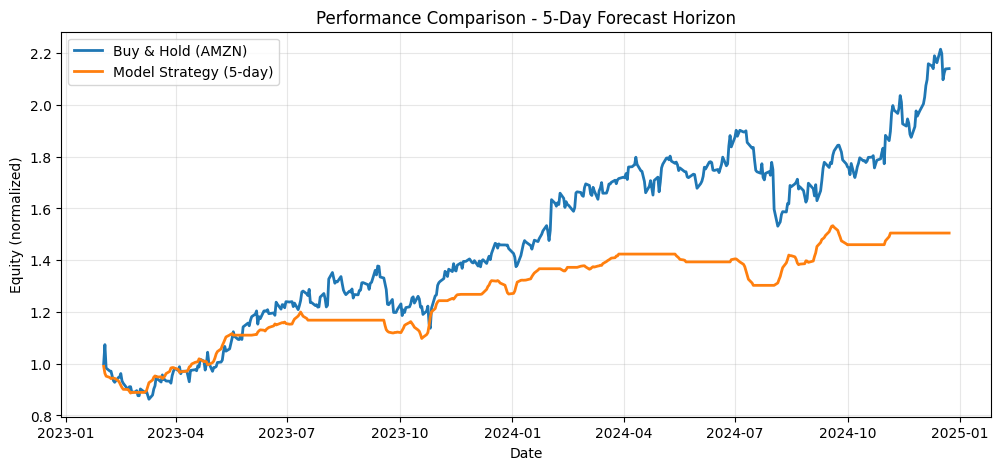


=== Evaluating Horizon 10 ===


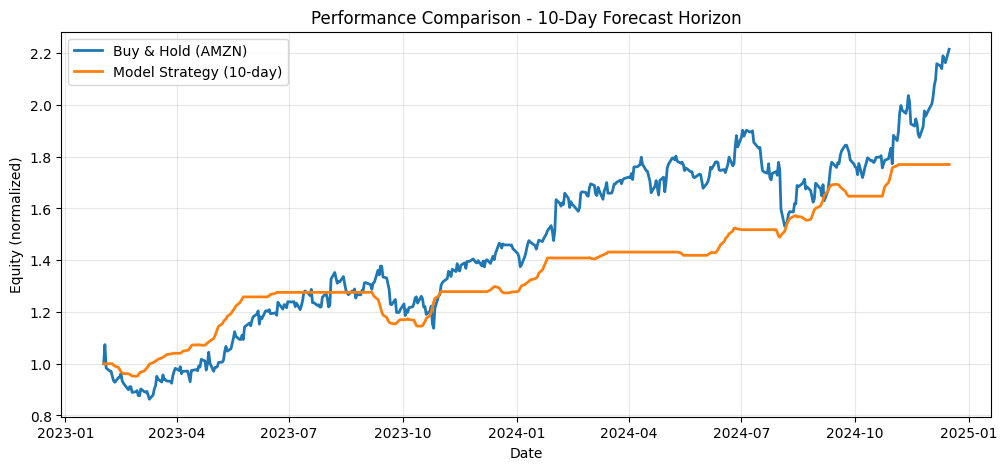


=== Evaluating Horizon 15 ===


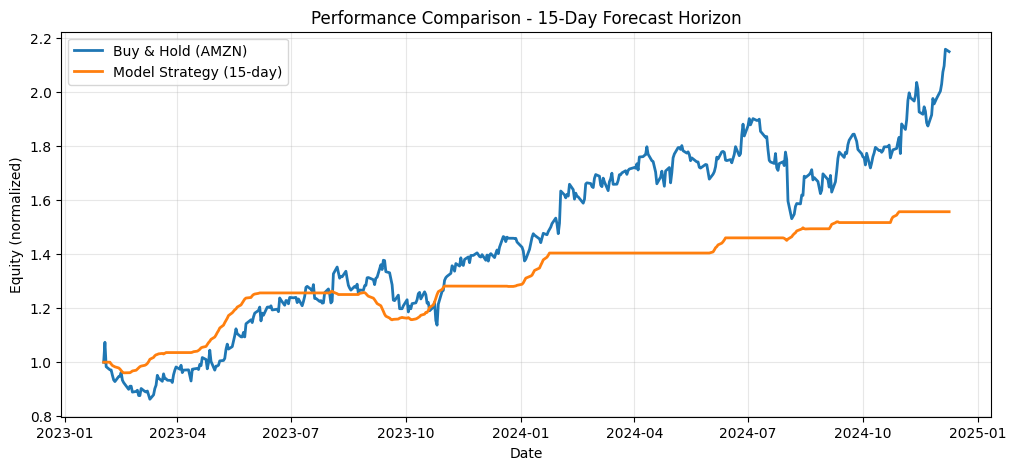


=== Evaluating Horizon 20 ===


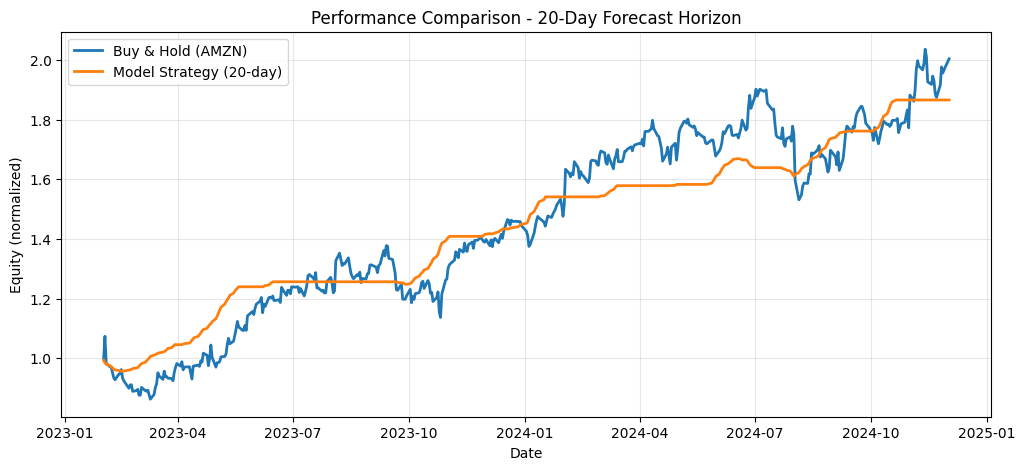


=== Evaluating Horizon 25 ===


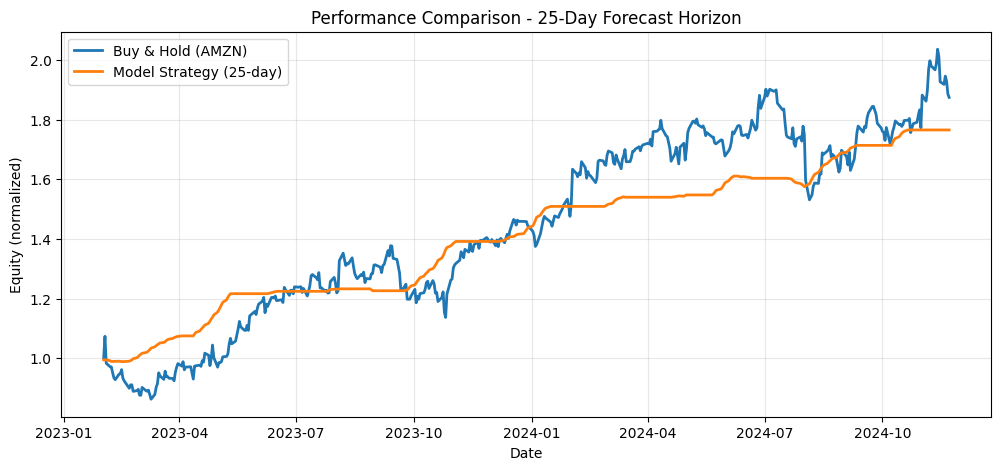


=== Evaluating Horizon 30 ===


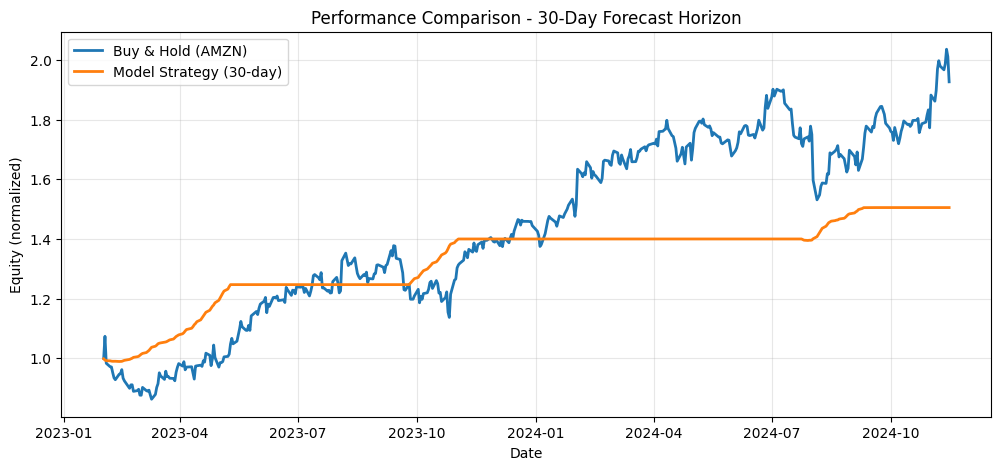

In [45]:
prediction_targets = [5, 10, 15, 20, 25, 30]

for t in prediction_targets:

    print(f"\n=== Evaluating Horizon {t} ===")

    # Load model and generate predictions
    result = load_model_and_predict(t, df=backtest_df)
    pred_df = result["predictions"]

    # Baseline performance
    backtest = run_long_only_backtest(pred_df, backtest_df)

    # Model strategy
    strat_df = run_model_strategy(pred_df, t)

    # Plot equity curves
    plot_comparison(backtest, strat_df, t)

In [46]:
for h in [15,20,25,30]:
    preds = load_model_and_predict(h, backtest_df)["predictions"]["prediction"]
    print(f"\n--- {h}-DAY MODEL ---")
    print(preds.describe())
    print("Unique values:", preds.nunique())
    print("Pct > 0:", (preds > 0).mean())


--- 15-DAY MODEL ---
count    467.000000
mean      -0.013335
std        0.058839
min       -0.123629
25%       -0.056577
50%       -0.019587
75%        0.019382
max        0.186788
Name: prediction, dtype: float64
Unique values: 467
Pct > 0: 0.38329764453961457

--- 20-DAY MODEL ---
count    462.000000
mean       0.000574
std        0.062734
min       -0.098853
25%       -0.050947
50%        0.004645
75%        0.043636
max        0.200959
Name: prediction, dtype: float64
Unique values: 462
Pct > 0: 0.5151515151515151

--- 25-DAY MODEL ---
count    457.000000
mean       0.005996
std        0.066557
min       -0.115889
25%       -0.035249
50%       -0.003356
75%        0.034700
max        0.196243
Name: prediction, dtype: float64
Unique values: 457
Pct > 0: 0.4726477024070022

--- 30-DAY MODEL ---
count    452.000000
mean      -0.016667
std        0.057369
min       -0.097119
25%       -0.058207
50%       -0.036072
75%        0.017606
max        0.148066
Name: prediction, dtype: float6

<Axes: >

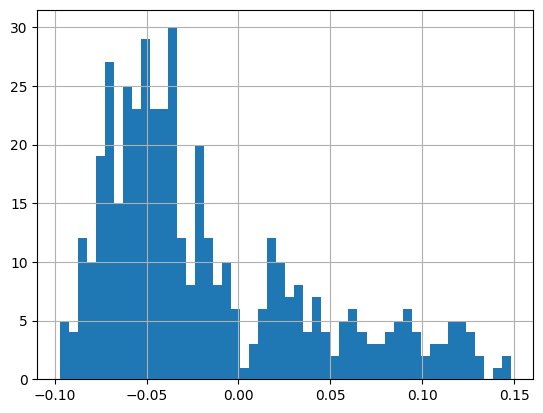

In [47]:
pred_df["prediction"].hist(bins=50)

#### NEAT implementation of NeuroEvolutionary network